In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
from math import ceil
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport

%matplotlib inline
sns.set()

# Reading the Data

In [2]:
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [3]:
df.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


# Make a copy of  original dataset

In [4]:
df_original = df.copy()

In [5]:
# Change The Column Namr
df.rename(columns={'CustID': 'ID', 'FirstPolYear': 'First Policy', 'BirthYear':'Birthday', 'EducDeg':'Education','MonthSal':'Salary','GeoLivArea':'Area','CustMonVal':'CMV', 'ClaimsRate':'Claims', 'PremMotor': 'Motor', 'PremHousehold':'Household','PremHealth': 'Health', 'PremLife':'Life', 'PremWork':'Work Compensation'  }, inplace=True)
df

,ID,First Policy,Birthday,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,10292.0,1984.0,1949.0,4 - PhD,3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78
10292,10293.0,1977.0,1952.0,1 - Basic,2431.0,3.0,0.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13
10293,10294.0,1994.0,1976.0,3 - BSc/MSc,2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89
10294,10295.0,1981.0,1977.0,1 - Basic,1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91


In [6]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10296 non-null  float64
 1   First Policy       10266 non-null  float64
 2   Birthday           10279 non-null  float64
 3   Education          10279 non-null  object 
 4   Salary             10260 non-null  float64
 5   Area               10295 non-null  float64
 6   Children           10275 non-null  float64
 7   CMV                10296 non-null  float64
 8   Claims             10296 non-null  float64
 9   Motor              10262 non-null  float64
 10  Household          10296 non-null  float64
 11  Health             10253 non-null  float64
 12  Life               10192 non-null  float64
 13  Work Compensation  10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [8]:
df.dtypes

ID                   float64
First Policy         float64
Birthday             float64
Education             object
Salary               float64
Area                 float64
Children             float64
CMV                  float64
Claims               float64
Motor                float64
Household            float64
Health               float64
Life                 float64
Work Compensation    float64
dtype: object

In [9]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,10296,NaN,NaN,NaN,5148.5,2972.34,1,2574.75,5148.5,7722.25,10296
First Policy,10266,NaN,NaN,NaN,1991.06,511.268,1974,1980,1986,1992,53784
Birthday,10279,NaN,NaN,NaN,1968.01,19.7095,1028,1953,1968,1983,2001
Education,10279,4,3 - BSc/MSc,4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary,10260,NaN,NaN,NaN,2506.67,1157.45,333,1706,2501.5,3290.25,55215
Area,10295,NaN,NaN,NaN,2.70986,1.26629,1,1,3,4,4
Children,10275,NaN,NaN,NaN,0.706764,0.455268,0,0,1,1,1
CMV,10296,NaN,NaN,NaN,177.893,1945.81,-165680,-9.44,186.87,399.778,11875.9
Claims,10296,NaN,NaN,NaN,0.742772,2.91696,0,0.39,0.72,0.98,256.2
Motor,10262,NaN,NaN,NaN,300.47,211.915,-4.11,190.59,298.61,408.3,11604.4


In [10]:
# Define metric and non-metric features. Why?
non_metric_features = ["Education"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Fill missing values (Data imputation)

In [11]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [12]:
# count of missing values
df_central.isna().sum()

ID                     0
First Policy          30
Birthday              17
Education             17
Salary                36
Area                   1
Children              21
CMV                    0
Claims                 0
Motor                 34
Household              0
Health                43
Life                 104
Work Compensation     86
dtype: int64

In [13]:
df_central.median()

ID                   5148.50
First Policy         1986.00
Birthday             1968.00
Salary               2501.50
Area                    3.00
Children                1.00
CMV                   186.87
Claims                  0.72
Motor                 298.61
Household             132.80
Health                162.81
Life                   25.56
Work Compensation      25.67
dtype: float64

In [14]:
modes = df_central[non_metric_features].mode().loc[0]
modes

Education    3 - BSc/MSc
Name: 0, dtype: object

In [15]:
df_central.fillna(df_central.median(), inplace=True)
df_central.fillna(modes, inplace=True)
df_central.isna().sum()

ID                   0
First Policy         0
Birthday             0
Education            0
Salary               0
Area                 0
Children             0
CMV                  0
Claims               0
Motor                0
Household            0
Health               0
Life                 0
Work Compensation    0
dtype: int64

In [16]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [17]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,ID,First Policy,Birthday,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
21,22.0,1977.0,1958.0,2 - High School,NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
68,69.0,1983.0,1977.0,2 - High School,1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
138,139.0,1979.0,1976.0,2 - High School,2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
143,144.0,1996.0,1990.0,3 - BSc/MSc,NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
184,185.0,1993.0,1984.0,2 - High School,2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,10011.0,NaN,1947.0,2 - High School,3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10057,10058.0,1983.0,1980.0,2 - High School,1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10142,10143.0,1986.0,1985.0,3 - BSc/MSc,1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78
10284,10285.0,1980.0,1987.0,3 - BSc/MSc,1504.0,4.0,1.0,-1.55,0.96,390.63,29.45,179.70,-6.00,NaN


In [18]:
# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [19]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

,ID,First Policy,Birthday,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
21,22.0,1977.0,1958.0,3125.0,3.0,1.0,111.37,0.80,407.520,111.70,100.130,24.670,30.340
68,69.0,1983.0,1977.0,1399.0,4.0,1.0,476.65,0.33,330.730,186.70,211.150,22.516,15.780
138,139.0,1979.0,1976.0,2538.0,2.0,1.0,149.59,0.69,194.260,305.60,204.994,37.340,17.670
143,144.0,1996.0,1990.0,2435.2,4.0,1.0,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
184,185.0,1993.0,1984.0,2419.0,4.0,1.0,-62.23,1.07,275.652,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,10011.0,1988.8,1947.0,3959.0,2.0,0.2,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10057,10058.0,1983.0,1980.0,1569.0,4.0,1.0,222.60,0.55,235.600,211.15,235.466,32.340,68.790
10142,10143.0,1986.0,1985.0,1652.0,3.0,1.0,55.67,0.88,257.050,94.45,308.390,24.916,13.780
10284,10285.0,1980.0,1987.0,1504.0,4.0,1.0,-1.55,0.96,390.630,29.45,179.700,-6.000,20.626


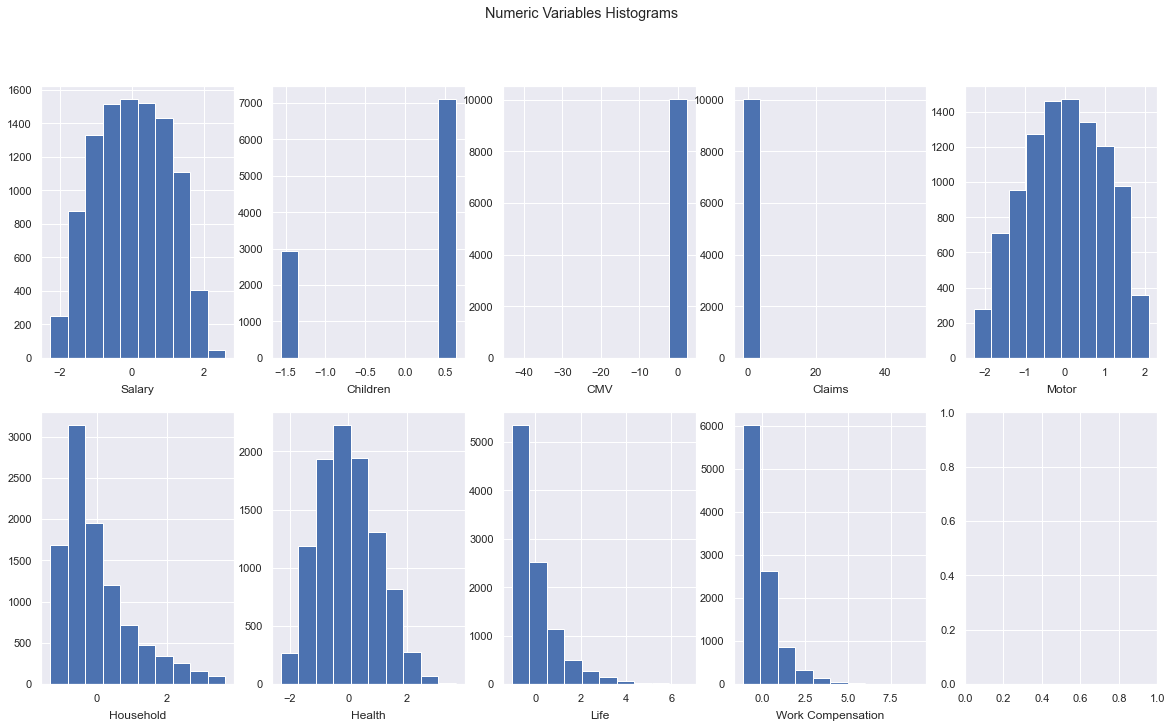

In [45]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat], bins = 10)
    ax.set_title(feat, y = -0.15)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Histograms"

plt.suptitle(title)

plt.show()

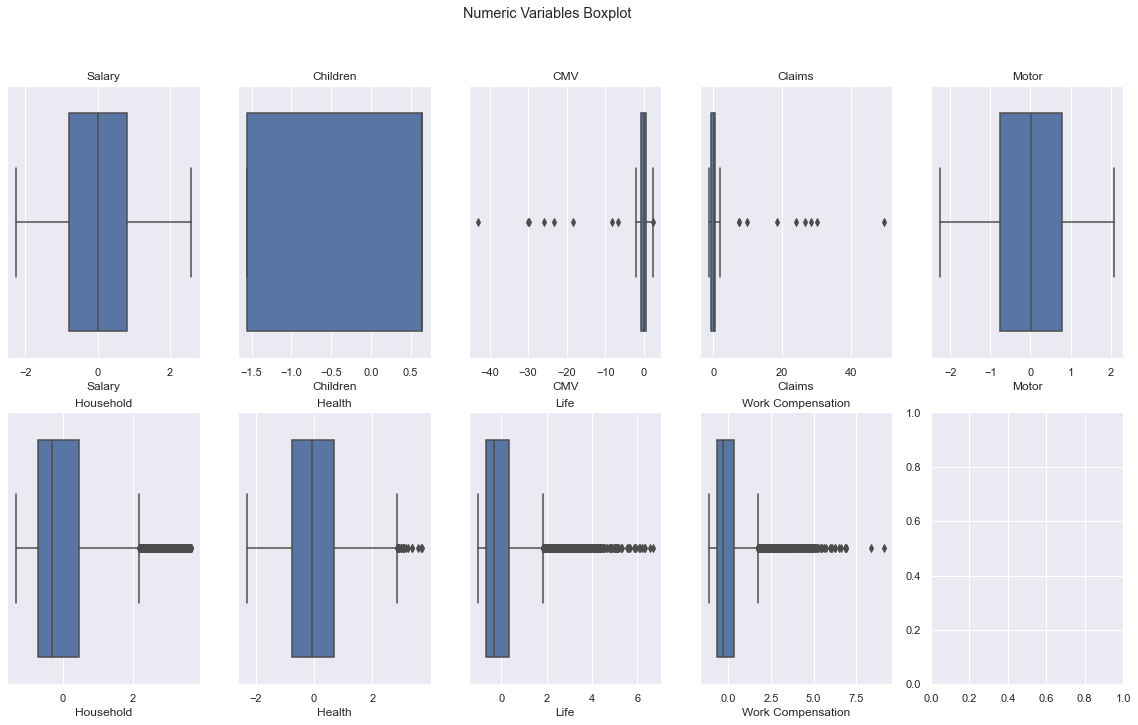

In [55]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(df[feat], ax = ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Boxplot"

plt.suptitle(title)

plt.show()

In [22]:
# let's keep the central imputation
df = df_central.copy()

# Outlier removal

In [23]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['Salary']<=6000)
    &
    (df['CMV']<=1000)
    &
    (df['Claims']<=30)
    &
    (df['Motor']<=1200)
    &
    (df['Household']<=900)
    &
    (df['Health']<=900)
    &
    (df['Life']<=350)
        
)

df_1 = df[filters1]

In [24]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9745


# Outlier removal using only the IQR method

In [25]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = df[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.8538


# Combining different outlier methods

In [26]:
df_3 = df[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9746


In [27]:
# Get the manual filtering version
df = df_3.copy()

# Feature Engineering

In [28]:
df['age'] = df['Birthday']
df['Birthday'] = datetime.now().year - df['age']
df['age']

0        1982.0
1        1995.0
2        1970.0
3        1981.0
4        1973.0
          ...  
10290    1999.0
10291    1949.0
10293    1976.0
10294    1977.0
10295    1981.0
Name: age, Length: 10034, dtype: float64

# Correlations Matricx

In [29]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.show()

In [30]:
cor_spearman = df_3.corr(method ='spearman')
cor_spearman

,ID,First Policy,Birthday,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
ID,1.000000,-0.013717,0.014508,-0.017246,-0.006161,0.000399,-0.008432,0.015033,-0.014764,0.015981,0.001926,0.010785,0.016938
First Policy,-0.013717,1.000000,-0.016311,0.019848,-0.004155,-0.011883,0.012982,-0.010979,-0.017478,0.012280,0.009622,0.011403,0.015234
Birthday,0.014508,-0.016311,1.000000,-0.927563,-0.014392,0.507124,0.018907,0.003640,-0.183758,0.130403,-0.010882,0.139687,0.151023
Salary,-0.017246,0.019848,-0.927563,1.000000,0.011123,-0.475095,-0.014783,-0.004503,0.167488,-0.117958,0.006665,-0.123591,-0.135551
Area,-0.006161,-0.004155,-0.014392,0.011123,1.000000,-0.024118,-0.006784,0.008823,-0.006478,0.010862,0.005332,0.010949,0.010570
Children,0.000399,-0.011883,0.507124,-0.475095,-0.024118,1.000000,0.011492,-0.032834,0.266164,-0.144077,-0.275710,-0.163938,-0.131639
CMV,-0.008432,0.012982,0.018907,-0.014783,-0.006784,0.011492,1.000000,-0.972093,0.004287,0.187827,-0.076052,-0.001677,0.011308
Claims,0.015033,-0.010979,0.003640,-0.004503,0.008823,-0.032834,-0.972093,1.000000,-0.105334,-0.037549,0.116872,0.072210,0.061370
Motor,-0.014764,-0.017478,-0.183758,0.167488,-0.006478,0.266164,0.004287,-0.105334,1.000000,-0.649935,-0.692431,-0.698471,-0.678929
Household,0.015981,0.012280,0.130403,-0.117958,0.010862,-0.144077,0.187827,-0.037549,-0.649935,1.000000,0.270733,0.463708,0.453788


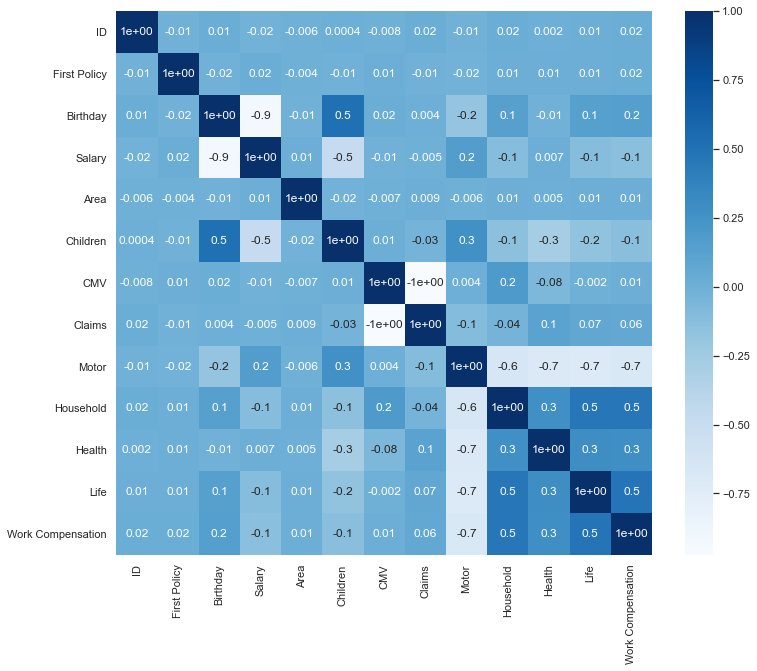

In [31]:
# DO IT
cor_heatmap(cor_spearman)

# Variable selection: Redundancy VS Relevancy

In [32]:
# Select variables according to their correlations
df.drop(columns=['Birthday', 'ID', 'First Policy','Area'], inplace=True)

In [33]:
# Updating metric_features
metric_features.remove('Birthday')
metric_features.remove('ID')
metric_features.remove('First Policy')
metric_features.remove('Area')

# Data Normalization

In [34]:
df_minmax = df.copy()

In [35]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[0.39334471, 1.        , 0.9603842 , ..., 0.33366294, 0.15282965,
        0.06232606],
       [0.07337884, 1.        , 0.92780314, ..., 0.26698429, 0.57011885,
        0.25484866],
       [0.41467577, 0.        , 0.9682543 , ..., 0.28471582, 0.26414827,
        0.23950985],
       ...,
       [0.55140785, 1.        , 0.96949049, ..., 0.32442637, 0.05565931,
        0.03643777],
       [0.34940273, 1.        , 0.95205475, ..., 0.45054723, 0.20062252,
        0.26947555],
       [0.52943686, 1.        , 0.96565087, ..., 0.32217902, 0.0393039 ,
        0.05369663]])

In [36]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)

Parameters fitted:
 [ 3.330000e+02  0.000000e+00 -1.471408e+04  0.000000e+00 -4.110000e+00
 -7.500000e+01 -2.110000e+00 -7.000000e+00 -1.200000e+01] 
 [5.02100e+03 1.00000e+00 1.00364e+03 2.53600e+01 5.85220e+02 8.99050e+02
 4.42860e+02 3.46400e+02 4.51530e+02]


In [37]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

,Education,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age
0,2 - High School,0.393345,1.0,0.960384,0.015379,0.644732,0.158565,0.333663,0.152830,0.062326,1982.0
1,2 - High School,0.073379,1.0,0.927803,0.044164,0.138411,0.504286,0.266984,0.570119,0.254849,1995.0
2,1 - Basic,0.414676,0.0,0.968254,0.011041,0.356778,0.307479,0.284716,0.264148,0.239510,1970.0
3,3 - BSc/MSc,0.163396,1.0,0.935065,0.039038,0.316614,0.121503,0.704047,0.119808,0.087028,1981.0
4,3 - BSc/MSc,0.305034,1.0,0.938387,0.035489,0.581559,0.126072,0.415084,0.072949,0.115311,1973.0


In [38]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2)

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
count,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00
mean,0.47,0.71,0.95,0.03,0.52,0.27,0.38,0.13,0.11
std,0.21,0.45,0.02,0.02,0.23,0.20,0.17,0.13,0.10
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.00,0.94,0.02,0.35,0.13,0.26,0.05,0.05
50%,0.47,1.00,0.95,0.03,0.52,0.21,0.37,0.09,0.08
75%,0.63,1.00,0.96,0.04,0.70,0.36,0.50,0.18,0.14
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [39]:
df_standard = df.copy()

In [40]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

array([[-0.35816621,  0.6414439 ,  0.51495829, ..., -0.30342227,
         0.14062536, -0.50287617],
       [-1.90586526,  0.6414439 , -0.9637638 , ..., -0.70311682,
         3.35959354,  1.46660032],
       [-0.25498627, -1.55898279,  0.87215009, ..., -0.59682797,
         0.99933702,  1.30968663],
       ...,
       [ 0.40639712,  0.6414439 ,  0.92825548, ..., -0.35878946,
        -0.60894654, -0.7677094 ],
       [-0.57071688,  0.6414439 ,  0.13691827, ...,  0.39722192,
         0.50929948,  1.6162311 ],
       [ 0.30012179,  0.6414439 ,  0.75399093, ..., -0.3722608 ,
        -0.73511211, -0.59115391]])

In [41]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [2.52412777e+03 7.08491130e-01 2.02633488e+02 6.92763604e-01
 3.02300043e+02 1.86185041e+02 1.68883547e+02 4.05675563e+01
 3.96760903e+01] 
 [9.39311163e+05 2.06531449e-01 1.19932373e+05 2.47815733e-01
 1.82030278e+04 3.76866965e+04 5.51034325e+03 2.09881419e+03
 2.05313507e+03]


In [42]:
df_standard[metric_features] = scaled_feat
df_standard.head()

,Education,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age
0,2 - High School,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0
1,2 - High School,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0
2,1 - Basic,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0
3,3 - BSc/MSc,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0
4,3 - BSc/MSc,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0


In [43]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
count,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.26,-1.56,-43.07,-1.39,-2.27,-1.35,-2.30,-1.04,-1.14
25%,-0.79,-1.56,-0.61,-0.59,-0.75,-0.71,-0.75,-0.67,-0.64
50%,-0.00,0.64,-0.05,0.05,0.01,-0.30,-0.07,-0.33,-0.31
75%,0.80,0.64,0.55,0.58,0.79,0.45,0.69,0.33,0.32
max,2.58,0.64,2.31,49.55,2.10,3.67,3.69,6.68,9.09


In [44]:
df = df_standard.copy()

# One-hot encoding

In [51]:
df_ohc = df.copy()

In [52]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head(15)

C:\Users\foazu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0


In [53]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD
0,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0,0.0,1.0,0.0,0.0
1,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0,0.0,1.0,0.0,0.0
2,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0,1.0,0.0,0.0,0.0
3,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0,0.0,0.0,1.0,0.0
4,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0,0.0,0.0,1.0,0.0


In [54]:
df = df_ohc.copy()

# Dimensionality Reduction: PCA

In [79]:
df_pca = df.copy()

# A more specific explanation of PCA

In [80]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  # What is this output?

array([[-8.58819080e-01, -7.87878604e-01,  6.06630304e-01, ...,
        -1.09420264e-01,  1.52353004e-02, -8.36246538e-02],
       [ 3.48436671e+00,  8.47873461e-01,  2.60360753e+00, ...,
         1.80695669e-03, -1.97996243e-01,  3.81424242e-02],
       [ 1.51890713e+00, -1.25113545e+00, -5.25793965e-01, ...,
         9.04131488e-01,  4.34910804e-03,  1.64594615e-01],
       ...,
       [-1.43505495e+00, -1.31375726e+00, -3.51202186e-02, ...,
        -4.30912294e-01,  6.62632481e-03, -5.00777871e-03],
       [ 1.52598261e+00, -2.21241566e-01,  8.93055789e-01, ...,
        -4.30483650e-01,  4.21612691e-02, -9.33086541e-02],
       [-1.52614645e+00, -1.09368521e+00,  6.49067231e-02, ...,
        -3.38801123e-01, -7.18211520e-03, -3.19521813e-02]])

In [81]:
pca_feat.shape

(10034, 9)

In [82]:
len(metric_features)

9

In [83]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.924770,0.000000,0.324942,0.324942
2,1.997866,-0.926905,0.221963,0.546905
3,1.569298,-0.428567,0.174349,0.721254
4,0.904956,-0.664342,0.100541,0.821795
5,0.594283,-0.310673,0.066025,0.887820
6,0.573335,-0.020948,0.063698,0.951517
7,0.404292,-0.169044,0.044917,0.996434
8,0.021955,-0.382336,0.002439,0.998873
9,0.010141,-0.011814,0.001127,1.000000


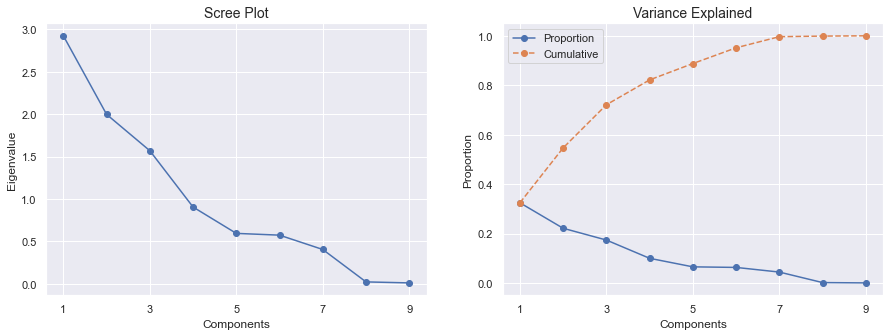

In [84]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [85]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df.head(10)

,PC0,PC1,PC2,PC3,PC4
0,-0.858819,-0.787879,0.606630,-0.228414,-0.293450
1,3.484367,0.847873,2.603608,1.377429,-0.933332
2,1.518907,-1.251135,-0.525794,1.264809,0.550912
3,0.785296,1.074083,0.717595,-2.385903,0.072725
4,-0.546414,0.669573,0.865091,-0.707944,0.447345
5,-1.858168,0.902093,0.547912,0.068747,0.003356
6,1.141062,1.370859,-2.735384,-0.901578,-0.062391
7,1.006787,1.050899,1.342325,0.395995,-0.468570
8,-0.964860,-0.643726,0.388824,-1.394934,0.106964
9,1.018411,1.540773,-2.192003,-0.182842,0.346194


In [86]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
0,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0,0.0,1.0,0.0,0.0,-0.858819,-0.787879,0.606630,-0.228414,-0.293450
1,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0,0.0,1.0,0.0,0.0,3.484367,0.847873,2.603608,1.377429,-0.933332
2,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0,1.0,0.0,0.0,0.0,1.518907,-1.251135,-0.525794,1.264809,0.550912
3,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0,0.0,0.0,1.0,0.0,0.785296,1.074083,0.717595,-2.385903,0.072725
4,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0,0.0,0.0,1.0,0.0,-0.546414,0.669573,0.865091,-0.707944,0.447345


# How do we interpret each Principal Component (with style)?

In [88]:
df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]

,PC0,PC1,PC2,PC3,PC4
Salary,-0.258789,0.073780,-0.810346,0.282933,0.023763
Children,-0.268342,-0.064240,0.818320,-0.236506,-0.005440
CMV,0.016900,-0.988388,-0.095716,-0.051510,0.000230
Claims,0.089595,0.975815,0.104552,0.080352,-0.038767
Motor,-0.975861,-0.019936,0.083794,0.159169,-0.015171
Household,0.720365,-0.182213,0.070188,0.186681,-0.254920
Health,0.529525,0.154315,-0.392178,-0.730981,0.015306
Life,0.723286,-0.020634,0.156833,0.301434,-0.375253
Work Compensation,0.708813,-0.033652,0.179984,0.272744,0.621179


In [89]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4
Salary,-0.258789,0.073780,-0.810346,0.282933,0.023763
Children,-0.268342,-0.064240,0.818320,-0.236506,-0.005440
CMV,0.016900,-0.988388,-0.095716,-0.051510,0.000230
Claims,0.089595,0.975815,0.104552,0.080352,-0.038767
Motor,-0.975861,-0.019936,0.083794,0.159169,-0.015171
Household,0.720365,-0.182213,0.070188,0.186681,-0.254920
Health,0.529525,0.154315,-0.392178,-0.730981,0.015306
Life,0.723286,-0.020634,0.156833,0.301434,-0.375253
Work Compensation,0.708813,-0.033652,0.179984,0.272744,0.621179
